In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from numpy._core.numerictypes import issubdtype
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import shap
import matplotlib.ticker as ticker

In [2]:
df = pd.read_csv('cr_loan2.csv')

In [3]:
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


# Data Cleaning and Optimisation

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


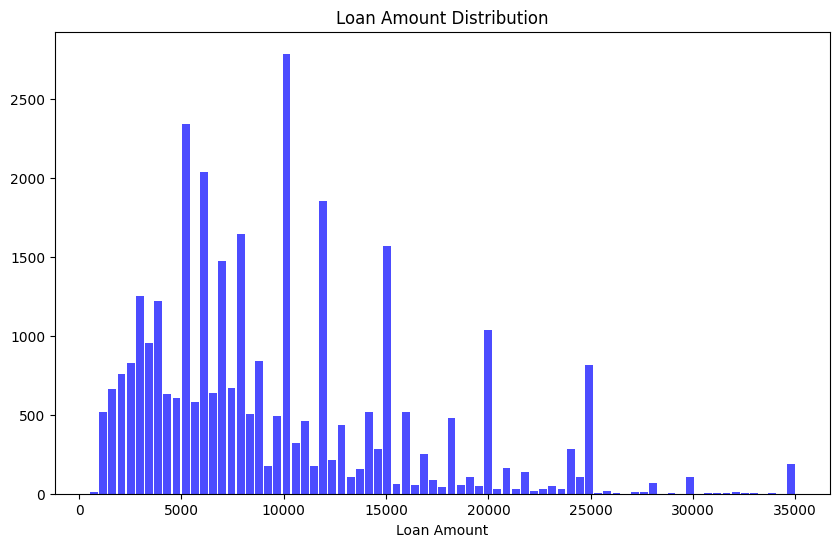

In [5]:
plt.figure(figsize=(10,6))
plt.hist(x=df['loan_amnt'], bins='auto', color='blue',alpha=0.7, rwidth=0.85)
plt.title('Loan Amount Distribution')
plt.xlabel("Loan Amount")
plt.show()

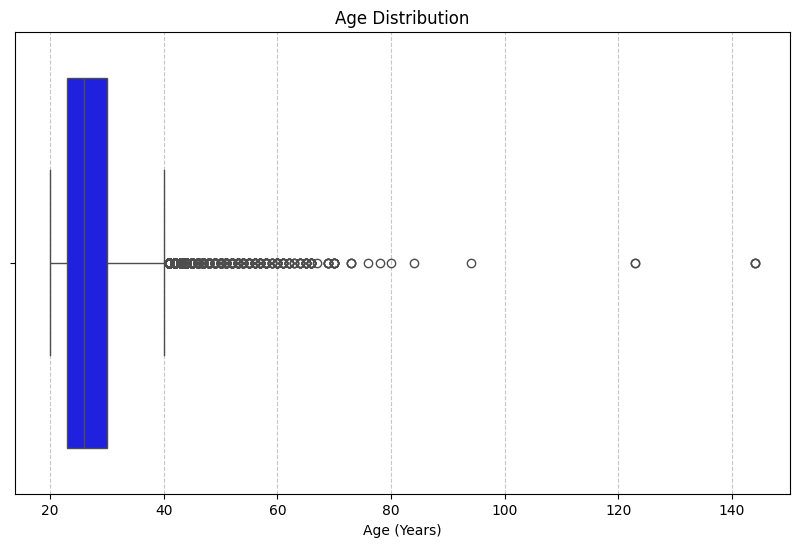

In [6]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df['person_age'], color= 'blue')
plt.title('Age Distribution')
plt.xlabel('Age (Years)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [7]:
# age outliers
age_outliers = df[(df['person_age'] < 18) | (df['person_age'] > 100)]
print(f"Detected {len(age_outliers)} age outliers")

Detected 5 age outliers


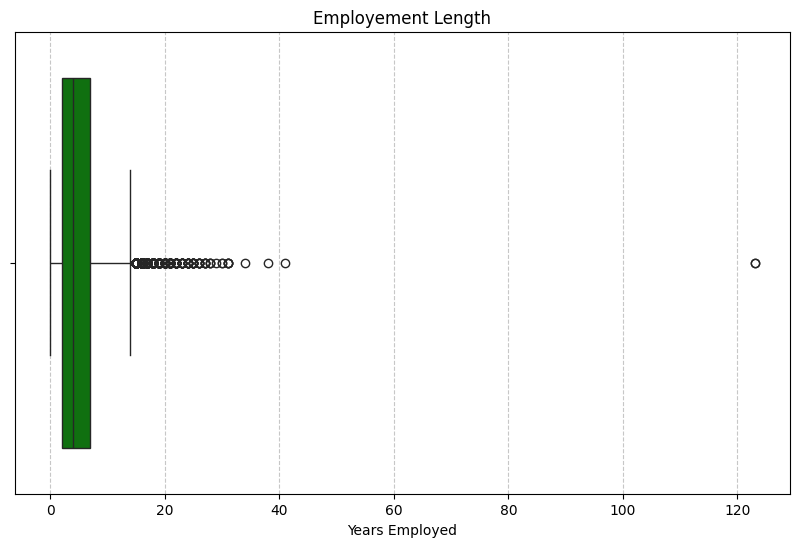

In [8]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df['person_emp_length'], color= 'green')
plt.title('Employement Length')
plt.xlabel('Years Employed')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [9]:
# employed outliers
emp_outliers = df[(df['person_emp_length'] < 0) | (df['person_emp_length'] > 60)]
print(f"Detected {len(emp_outliers)} employed outliers")

Detected 2 employed outliers


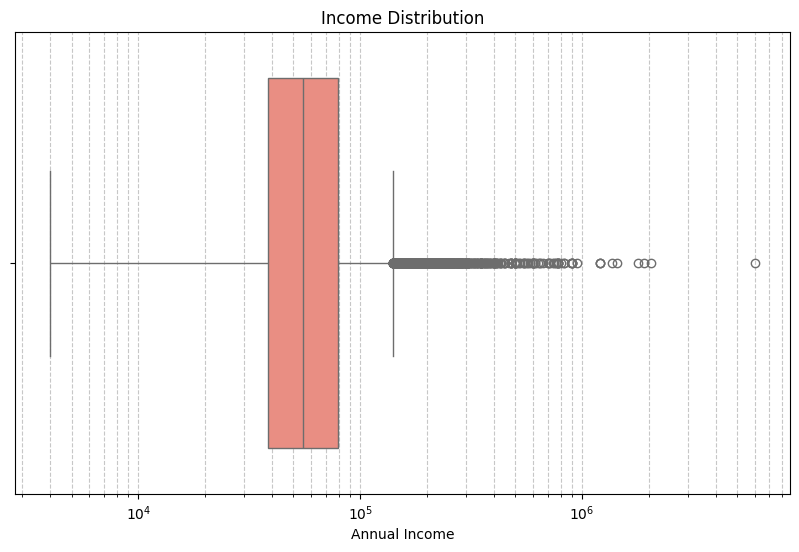

In [10]:
plt.figure(figsize=(10,6))
sns.boxplot(x=df['person_income'], color= 'salmon')
plt.title('Income Distribution')
plt.xscale('log')
plt.xlabel('Annual Income')
plt.grid(axis='x', linestyle='--', alpha=0.7, which='both')
plt.show()

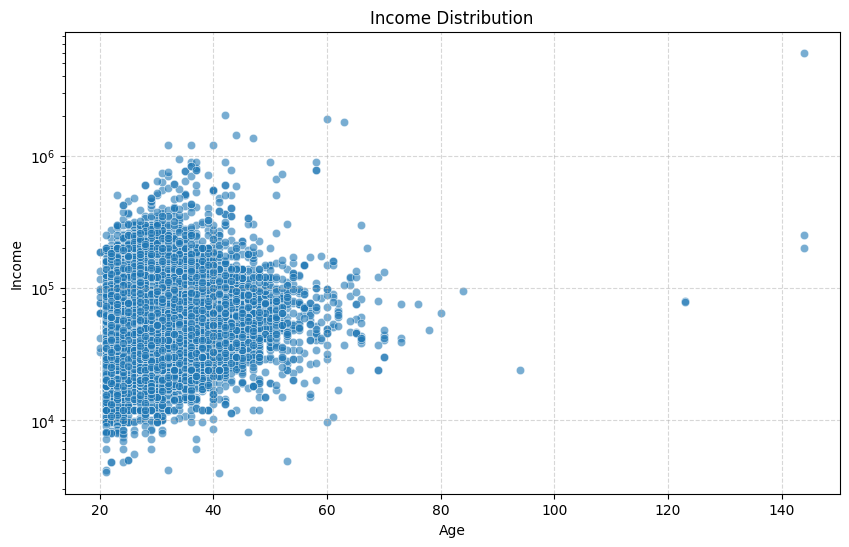

In [11]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df['person_age'],y=df['person_income'], alpha=0.6, )
plt.title('Income Distribution')
plt.xlabel('Age')
plt.ylabel('Income')
plt.yscale('log') #log scaled the y axis
plt.grid(axis='both', linestyle='--', alpha=0.5)
plt.show()

In [12]:
df_clean= df[(df['person_emp_length'] < 60) & (df['person_age'] <= 100)].copy()

In [13]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31679 entries, 1 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  31679 non-null  int64  
 1   person_income               31679 non-null  int64  
 2   person_home_ownership       31679 non-null  object 
 3   person_emp_length           31679 non-null  float64
 4   loan_intent                 31679 non-null  object 
 5   loan_grade                  31679 non-null  object 
 6   loan_amnt                   31679 non-null  int64  
 7   loan_int_rate               28632 non-null  float64
 8   loan_status                 31679 non-null  int64  
 9   loan_percent_income         31679 non-null  float64
 10  cb_person_default_on_file   31679 non-null  object 
 11  cb_person_cred_hist_length  31679 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.1+ MB


In [14]:
print(f"\nOriginal Dataframe shape: {df.shape}")
print(f"Cleaned Dataframe shape: {df_clean.shape}")
print(f"Removed {df.shape[0] - df_clean.shape[0]} rows")


Original Dataframe shape: (32581, 12)
Cleaned Dataframe shape: (31679, 12)
Removed 902 rows


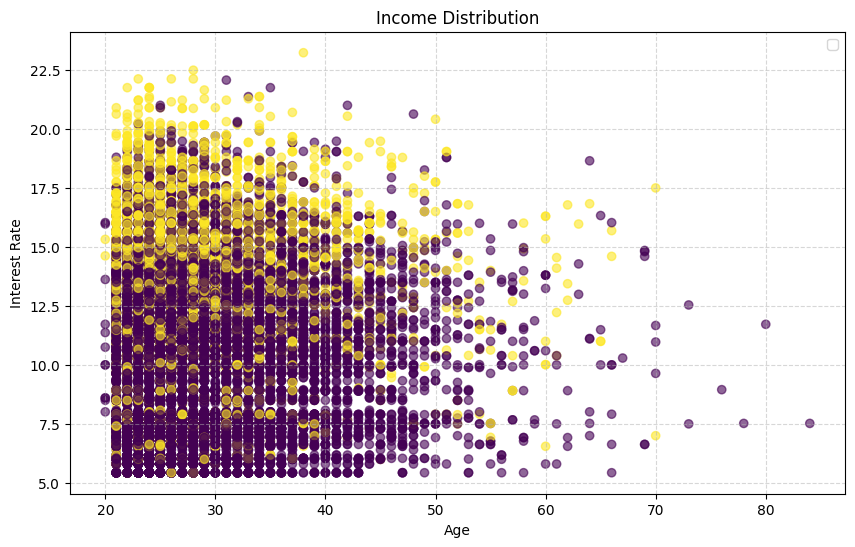

In [15]:
plt.figure(figsize=(10,6))
plt.scatter(x=df_clean['person_age'],y=df_clean['loan_int_rate'], c=df_clean['loan_status'], alpha=0.6, )
plt.title('Income Distribution')
plt.xlabel('Age')
plt.ylabel('Interest Rate')
plt.legend()
plt.grid(axis='both', linestyle='--', alpha=0.5)
plt.show()

In [16]:
df_clean.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length                0
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3047
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [17]:
df_clean.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,31679.000000,3.167900e+04,31679.000000,31679.000000,28632.000000,31679.000000,31679.000000,31679.000000
mean,27.730673,6.649010e+04,4.782064,9659.962436,11.039701,0.215442,0.169610,5.809211
std,6.213427,5.276879e+04,4.034948,6334.360554,3.229409,0.411135,0.106269,4.059710
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.936600e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.600000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,8.000000e+04,7.000000,12500.000000,13.480000,0.000000,0.230000,8.000000
max,94.000000,2.039784e+06,41.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [18]:
df_clean['loan_int_rate']= df_clean['loan_int_rate'].fillna(df_clean.groupby('loan_grade')['loan_int_rate'].transform('median'))

In [19]:
df_clean.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [20]:
print(pd.crosstab(df['loan_intent'], df['loan_status'], margins=True))

loan_status            0     1    All
loan_intent                          
DEBTCONSOLIDATION   3722  1490   5212
EDUCATION           5342  1111   6453
HOMEIMPROVEMENT     2664   941   3605
MEDICAL             4450  1621   6071
PERSONAL            4423  1098   5521
VENTURE             4872   847   5719
All                25473  7108  32581


# Feature Engineering

In [21]:
# calculate WoE (Weight of Evidence) and IV (Information Value)
def calculate_woe_iv(dataset, feature, target):
    lst = []

    # Define a temporary column name for the binned/grouped feature
    bin_col_name = f'{feature}_binned'

    # Binning
    if np.issubdtype(dataset[feature].dtype, np.number) and dataset[feature].nunique()>10:
        dataset[bin_col_name] = pd.qcut(dataset[feature], q=10, duplicates='drop')
    else:
        # Use .copy() to ensure a copy of the Series is assigned
        dataset[bin_col_name] = dataset[feature].copy()

    # Calculate Good(0) and Bad(1) counts
    # Ensure that our target is 1 for Default and 0 for Paid
    grouped= dataset.groupby(bin_col_name, observed=False)[target].agg(['count', 'sum'])
    grouped.rename(columns={'count': 'total', 'sum': 'bad'}, inplace=True)
    grouped['good'] = grouped['total'] - grouped['bad']

    # Probability Distribution Calculations
    total_good= grouped['good'].sum()
    total_bad= grouped['bad'].sum()

    # Avoid division by zero
    grouped['good_dist'] = grouped['good'] / total_good if total_good > 0 else 0
    grouped['bad_dist'] = grouped['bad'] / total_bad if total_bad > 0 else 0

    # Calculate WoE and IV
    # adding a tiny epsilon 0.0001 to avoid dividing by 0 or taking log of 0
    grouped['woe'] = np.log((grouped['good_dist'] + 0.0001) / (grouped['bad_dist'] + 0.0001))
    grouped['iv'] = (grouped['good_dist'] - grouped['bad_dist']) * grouped['woe']
    iv = grouped['iv'].sum()

    # Drop the temporary column after calculation to avoid modifying the original dataset excessively
    dataset.drop(columns=[bin_col_name], inplace=True)

    return grouped, iv

In [22]:
features= ['loan_grade','person_home_ownership','person_income','loan_int_rate','person_age']
iv_scores={}

for col in features:
  woe_table,iv = calculate_woe_iv(df_clean, col, 'loan_status')
  iv_scores[col] = iv

  if col =='loan_grade':
    print(f"WoE Table for {col}:")
    print(woe_table.sort_values(by='woe', ascending=False))
    print(f"IV Score for {col}: {iv}")

WoE Table for loan_grade:
                   total   bad  good  good_dist  bad_dist       woe        iv
loan_grade_binned                                                            
A                  10370   991  9379   0.377364  0.145201  0.954664  0.221637
B                  10183  1622  8561   0.344452  0.237656  0.371000  0.039621
C                   6319  1283  5036   0.202623  0.187985  0.074946  0.001097
D                   3555  2089  1466   0.058984  0.306081 -1.645207  0.406524
E                    952   611   341   0.013720  0.089524 -1.869495  0.141715
F                    236   166    70   0.002816  0.024322 -2.125132  0.045703
G                     64    63     1   0.000040  0.009231 -4.197753  0.038580
IV Score for loan_grade: 0.8948767467330276


In [23]:
# Summary Of Predictors
print("Summary of IV Scores:")
iv_df= pd.DataFrame(list(iv_scores.items()), columns=['Features', 'IV'])
print(iv_df)

Summary of IV Scores:
                Features        IV
0             loan_grade  0.894877
1  person_home_ownership  0.374627
2          person_income  0.456908
3          loan_int_rate  0.748327
4             person_age  0.010245


In [24]:
from numpy._core.numerictypes import issubdtype

features= ['loan_grade','person_home_ownership','person_income','loan_int_rate','person_age']
# WoE Mapping by using the function
df_woe= pd.DataFrame()
woe_mapping={} # to store logic for later use

for col in features:
  # get the WoE table gain
  woe_table, iv = calculate_woe_iv(df_clean, col, 'loan_status')

  # storng mapping logic for reference
  woe_mapping[col]= woe_table

  # Now we do mapping
  if issubdtype(df_clean[col].dtype, np.number) and df_clean[col].nunique() > 10:
    feature_series= pd.qcut(df_clean[col], q=10, duplicates='drop')
  else:
    feature_series= df_clean[col]

  # Mapping WoE values Directly
  df_woe[col+'_woe']= feature_series.map(woe_table['woe'])

# adding the variable back
df_woe['target']= df_clean['loan_status']

print("Transformed Data Head:")
print(df_woe.head())

Transformed Data Head:
   loan_grade_woe  person_home_ownership_woe person_income_woe  \
1        0.371000                   1.302178         -1.149633   
2        0.074946                   0.657655         -1.149633   
3        0.074946                  -0.495905          0.391715   
4        0.074946                  -0.495905          0.199354   
5        0.954664                   1.302178         -1.149633   

  loan_int_rate_woe person_age_woe  target  
1          0.304268      -0.217875       0  
2          0.149029      -0.027835       1  
3         -0.933420       0.014280       1  
4         -0.933420       0.007464       1  
5          1.001885      -0.217875       1  


# Logistic Regression

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [26]:
X = df_woe.drop('target', axis=1)
y = df_woe['target']

# using 70/30 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [27]:
model_lr= LogisticRegression( solver= 'lbfgs', C=1.0)
model_lr.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [28]:
y_pred_prob= model_lr.predict_proba(X_test)[:,1]

In [29]:
# Calculate AUC
auc = roc_auc_score(y_test, y_pred_prob)
print(f"Model Performance (AUC): {auc}")

Model Performance (AUC): 0.8312334329003171


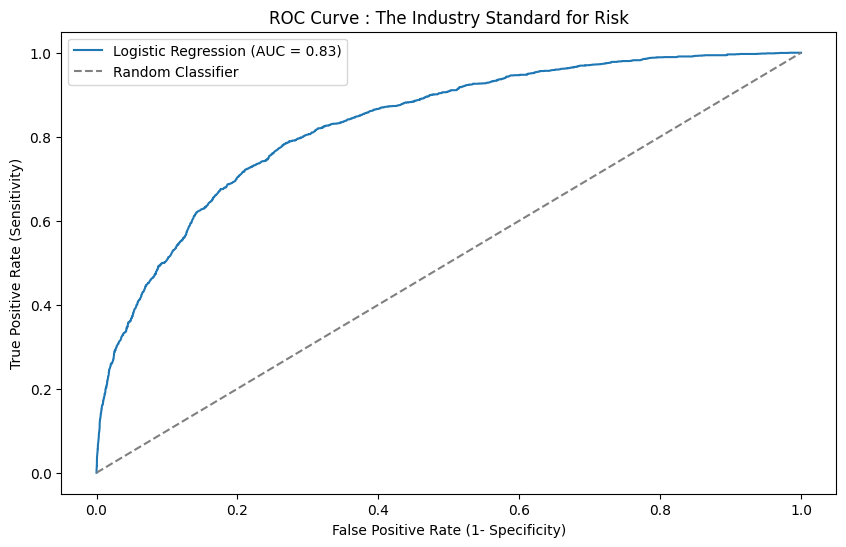

In [30]:
#ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(10,6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey',linestyle='--' ,label='Random Classifier')
plt.xlabel('False Positive Rate (1- Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve : The Industry Standard for Risk')
plt.legend()
plt.show()

In [31]:
# Coefficients (Buisness Logic Check)
# In WoE all coefficients sould theoritically be POSITIVE(~1.0)
# as high WoE= good, Tareget 0= good
# if target 1= Bad, high WoE= Good (low risk), the coefficients should be NEGATIVE
coef_df= pd.DataFrame(model_lr.coef_[0], index=X.columns, columns=['Coefficients'])
print(coef_df)

                           Coefficients
loan_grade_woe                -1.112768
person_home_ownership_woe     -0.795798
person_income_woe             -1.045233
loan_int_rate_woe             -0.013326
person_age_woe                -0.019449


# XGBoost model Integration

In [32]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

In [33]:
df_xgb= df_clean.copy()

#categorical columns
cat_cols= df_xgb.select_dtypes(include=['object']).columns

#Label Encoding
for col in cat_cols:
  le= LabelEncoder()
  df_xgb[col]= le.fit_transform(df_xgb[col].astype(str))

In [34]:
X_xgb= df_xgb.drop('loan_status', axis=1)
y_xgb= df_xgb['loan_status']

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_xgb, y_xgb, test_size=0.3, random_state=42, stratify=y_xgb)

In [35]:
# train the challenger
# scale_pos_wt= helps with any imbalances (toral neg/  Total pos)
ratio= sum(y_train_xgb == 0)/ sum(y_train_xgb == 1)

In [36]:
model_xgb= xgb.XGBClassifier(objective='binary:logistic',
                             scale_pos_weight=ratio, # handle class imbalaces
                             learning_rate=0.1,
                             max_depth=4, # keep trees shallow to prevent overfitting
                             n_estimators=100, #no of trees
                             eval_metric='auc',
                             random_state=42)
model_xgb.fit(X_train_xgb, y_train_xgb)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [37]:
y_pred_prob_xgb= model_xgb.predict_proba(X_test_xgb)[:,1]
auc_score_xgb= roc_auc_score(y_test_xgb, y_pred_prob_xgb)
print(f"Model Performance (AUC): {auc_score_xgb}")

Model Performance (AUC): 0.9362788712006269


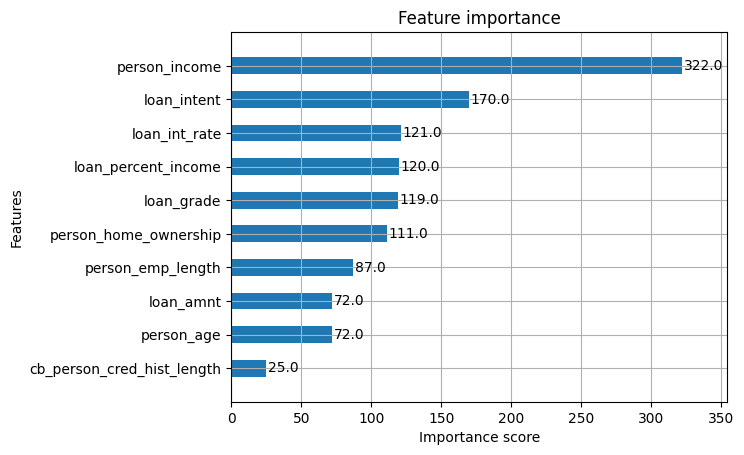

In [38]:
# Feature Plot
xgb.plot_importance(model_xgb,importance_type='weight', max_num_features=10, height=0.5)
plt.show()

# Strategy Table

In [39]:
# We use the test set from XGBoost Split
test_df= X_test_xgb.copy()
test_df['actual_default']= y_test_xgb
test_df['pred_prob']= y_pred_prob_xgb

In [40]:
# Recover Loan Amounts and rates
raw_test_data= df_clean.loc[test_df.index]
test_df['loan_amnt']= raw_test_data['loan_amnt']
test_df['loan_int_rate']= raw_test_data['loan_int_rate']

In [41]:
# Defining Financial Parameters
LGD =1.0 # Loss Given Default(Conservative: We lose the 100% of the loan if they default)
# in reality, LGD~0.6, (bank recover 40%), but we will be strict here

def calculate_portfolio_value(df, threshold):
  #Accept loanss below the thresholds
  accepted_loans= df[df['pred_prob']< threshold]

  # Portfolio Metrics
  count= len(accepted_loans)
  if count==0: return 0,0,0,0

  # acceptance rate
  accept_rate= count/ len(df)
  # Bad Rate (Actual defaults in acceptance pool)
  bad_rate= accepted_loans['actual_default'].mean()

  # Calculating Financial Impacts
  # Revenue= Loan Amount * Interest Rate
  # Loss: Loan Amount (if they actually defaaulted) * LGD
  potential_revenue= accepted_loans['loan_amnt']* (accepted_loans['loan_int_rate']/100)
  actual_loss= accepted_loans[accepted_loans['actual_default']==1]['loan_amnt'] * LGD

  net_profit= potential_revenue.sum() - actual_loss.sum()

  return count, accept_rate, bad_rate, net_profit

In [42]:
thresholds= np.arange(0.05,0.55,0.05)
strategy_data=[]

for t in thresholds:
  count, accept_rate, bad_rate, net_profit= calculate_portfolio_value(test_df, t)
  strategy_data.append([t, count, accept_rate, bad_rate, net_profit])

strategy_df= pd.DataFrame(strategy_data, columns=['Threshold', 'Loans Issued', 'Acceptance Rate', 'Bad Rate', 'Net Profit ($)'])

pd.options.display.float_format= '{:.2f}'.format
print("------------ Banking Strategy Table ---------")
print('\n',strategy_df)

------------ Banking Strategy Table ---------

    Threshold  Loans Issued  Acceptance Rate  Bad Rate  Net Profit ($)
0       0.05          1451             0.15      0.00      1150575.91
1       0.10          2361             0.25      0.01      1777322.79
2       0.15          3288             0.35      0.01      2451539.93
3       0.20          4316             0.45      0.02      3033372.67
4       0.25          5154             0.54      0.03      3371478.48
5       0.30          5866             0.62      0.04      3464418.81
6       0.35          6407             0.67      0.04      3537985.89
7       0.40          6813             0.72      0.05      3535160.59
8       0.45          7130             0.75      0.05      3304451.45
9       0.50          7374             0.78      0.06      3226801.98


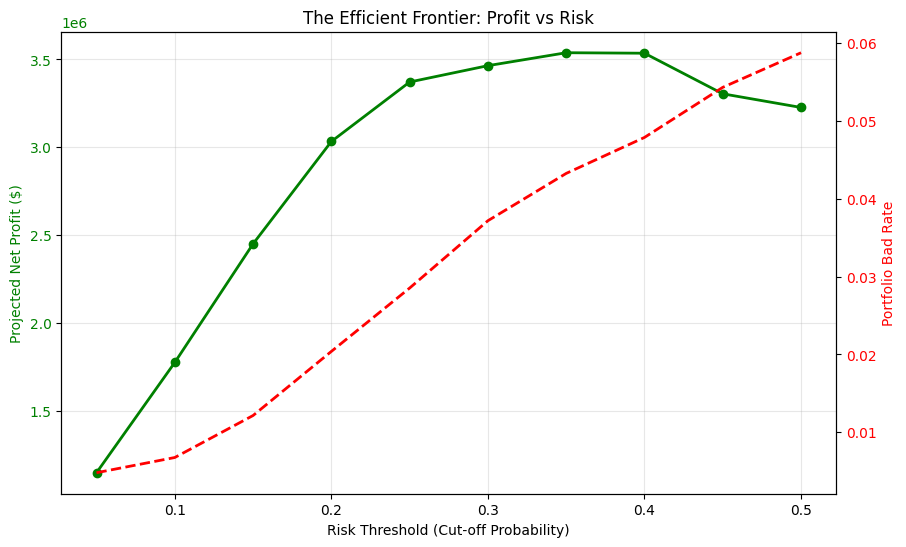

In [43]:
# Visulaisation
fig, ax1= plt.subplots(figsize=(10,6))

#Plot Net Profit
ax1.set_xlabel('Risk Threshold (Cut-off Probability)')
ax1.set_ylabel('Projected Net Profit ($)', color='green')
ax1.plot(strategy_df['Threshold'], strategy_df['Net Profit ($)'], marker='o', linestyle='-', color='green', linewidth=2)
ax1.tick_params(axis='y', labelcolor='green')
ax1.grid( True, alpha=0.3)

# Plot Bad Rate on Secondary Axis
ax2= ax1.twinx()
ax2.set_ylabel('Portfolio Bad Rate', color='red')
ax2.plot(strategy_df['Threshold'], strategy_df['Bad Rate'], linestyle='--', color='red', linewidth=2)
ax2.tick_params(axis='y', labelcolor='red')

plt.title('The Efficient Frontier: Profit vs Risk')
plt.show()

# Explainability with SHAP

In [44]:
import shap

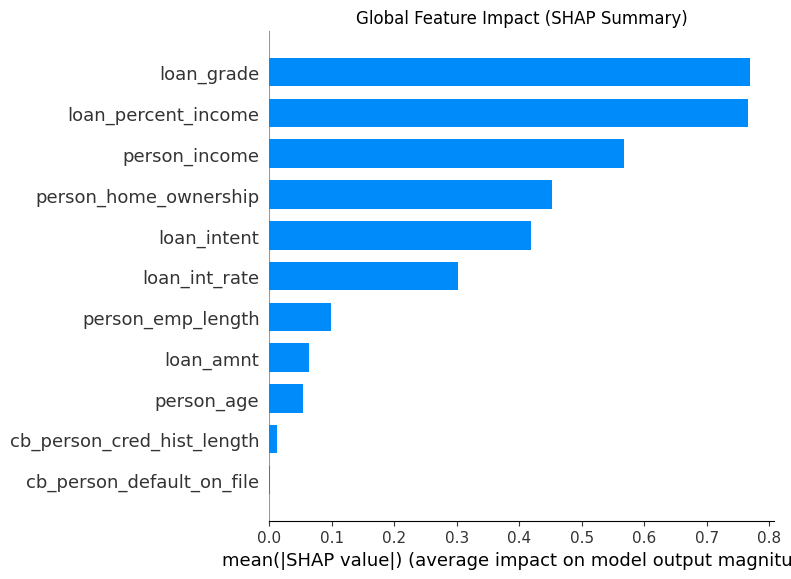

Explaining a Single Prediction
Actual Outcome: Paid


In [45]:
# Initializing the explainer
# we use Tree Explainer as XGBoost is a tree based model
explainer= shap.TreeExplainer(model_xgb)

# Calculate SHAP
# we take 1000 sample rows from test set to speed up plotting
X_sample= X_test_xgb.sample(1000, random_state=42)
shap_values= explainer.shap_values(X_sample)

# Global Interpretability (Beeswarm Plot)
plt.figure(figsize=(10,6))
plt.title('Global Feature Impact (SHAP Summary)')
shap.summary_plot(shap_values, X_sample, plot_type='bar')
plt.show()

# Local Interpretability (Force Plot)
shap.initjs()

print('Explaining a Single Prediction')
target_idx=X_sample.index[0]
actual= y_test_xgb[target_idx]
print(f"Actual Outcome: {'Default' if actual==1 else 'Paid'}")

#force plot
shap.force_plot(explainer.expected_value, shap_values[0,:], X_sample.iloc[0,:])

# Visuals

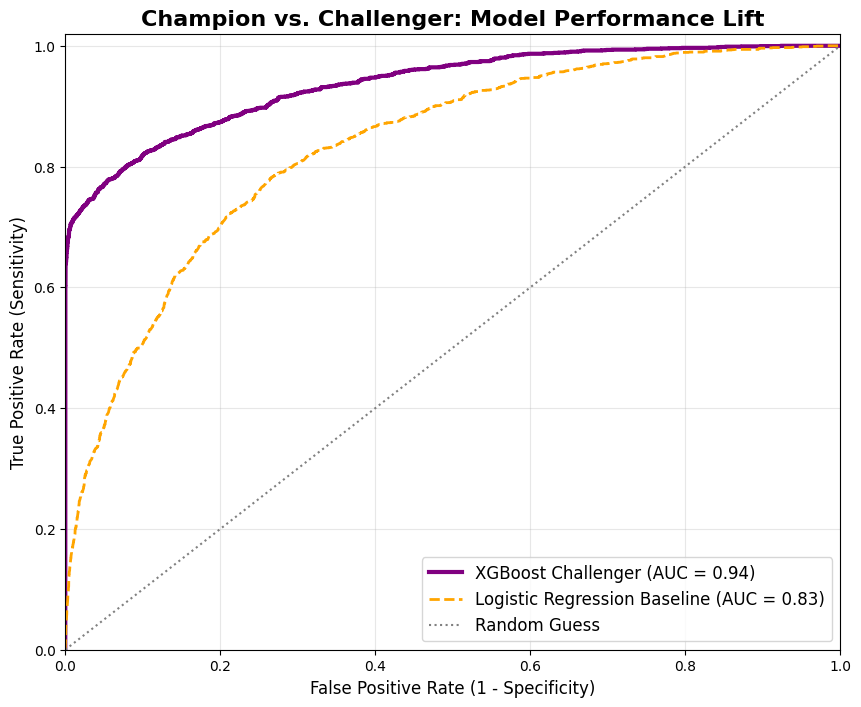

In [47]:

# DATA PREPARATION
# Ensure you have your trained models and test data ready from previous steps
# 1. Logistic Regression Predictions (Champion)
# Note: Ensure X_test corresponds to the WoE transformed data used for LogReg
y_pred_lr = model_lr.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_pred_lr)

# 2. XGBoost Predictions (Challenger)
# Note: Ensure X_test_xgb corresponds to the raw/encoded data used for XGBoost
y_pred_xgb = model_xgb.predict_proba(X_test_xgb)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_xgb, y_pred_xgb)
auc_xgb = roc_auc_score(y_test_xgb, y_pred_xgb)

# PLOTTING
plt.figure(figsize=(10, 8))

# Plot XGBoost (The Winner) - Solid Line
plt.plot(fpr_xgb, tpr_xgb, color='purple', linewidth=3,
         label=f'XGBoost Challenger (AUC = {auc_xgb:.2f})')

# Plot Logistic Regression (The Baseline) - Dashed Line
plt.plot(fpr_lr, tpr_lr, color='orange', linestyle='--', linewidth=2,
         label=f'Logistic Regression Baseline (AUC = {auc_lr:.2f})')

# Plot Random Guess Line
plt.plot([0, 1], [0, 1], color='gray', linestyle=':', label='Random Guess')
plt.title('Champion vs. Challenger: Model Performance Lift', fontsize=16, fontweight='bold')
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim([0, 1])
plt.ylim([0, 1.02])

# Save
plt.savefig('roc_curve_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

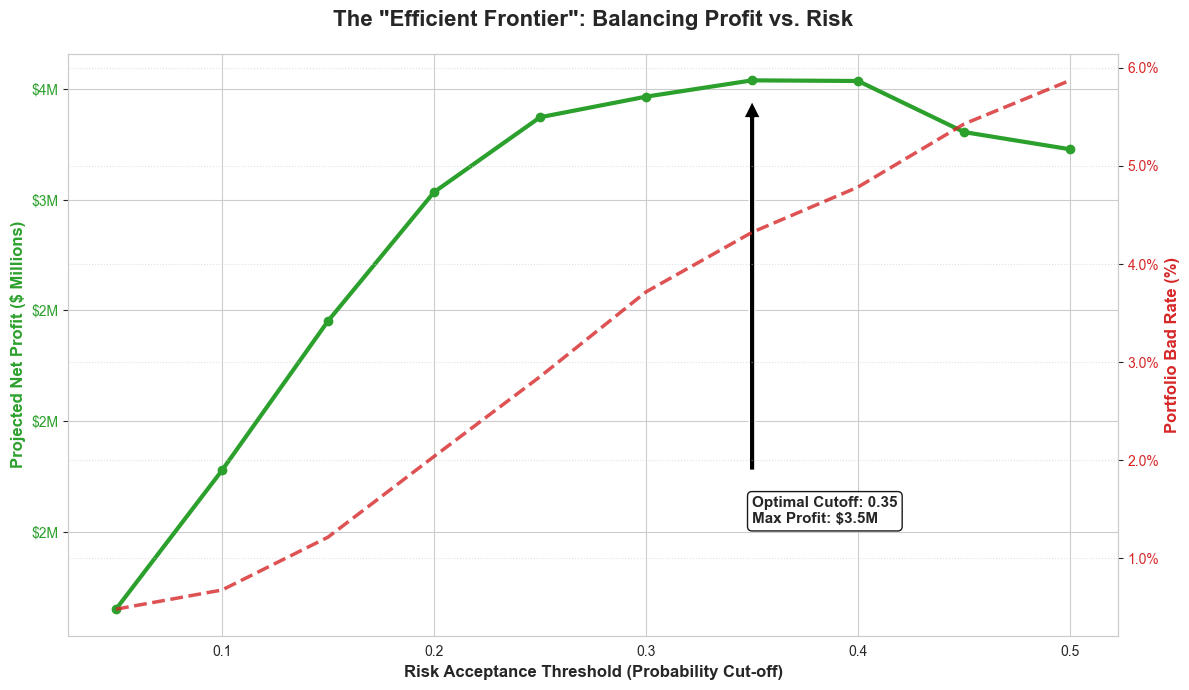

In [48]:

# Set a professional style
sns.set_style("whitegrid")

# Create the figure and the primary axis (Left: Profit)
fig, ax1 = plt.subplots(figsize=(12, 7))

# 1. Plot Net Profit (Green Line)
# We divide by 1,000,000 to make the y-axis readable ($ Millions)
profit_millions = strategy_df['Net Profit ($)'] / 1_000_000
color_profit = 'tab:green'

ax1.set_xlabel('Risk Acceptance Threshold (Probability Cut-off)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Projected Net Profit ($ Millions)', color=color_profit, fontsize=12, fontweight='bold')
ax1.plot(strategy_df['Threshold'], profit_millions, color=color_profit, linewidth=3, marker='o', label='Net Profit')
ax1.tick_params(axis='y', labelcolor=color_profit)

# Format y-axis as currency (e.g., $10M)
fmt = '${x:,.0f}M'
tick = ticker.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick)

# 2. Plot Bad Rate (Red Dotted Line) on the Secondary Axis
ax2 = ax1.twinx()
color_risk = 'tab:red'

ax2.set_ylabel('Portfolio Bad Rate (%)', color=color_risk, fontsize=12, fontweight='bold')
ax2.plot(strategy_df['Threshold'], strategy_df['Bad Rate'] * 100, color=color_risk, linestyle='--', linewidth=2.5, alpha=0.8, label='Bad Rate')
ax2.tick_params(axis='y', labelcolor=color_risk)

# Format y-axis as percentage
ax2.yaxis.set_major_formatter(ticker.PercentFormatter())

# 3. Highlight the Optimal Point
# Find the threshold with maximum profit
best_idx = strategy_df['Net Profit ($)'].idxmax()
best_threshold = strategy_df.loc[best_idx, 'Threshold']
best_profit = strategy_df.loc[best_idx, 'Net Profit ($)'] / 1_000_000

# Annotate the "Sweet Spot"
ax1.annotate(f'Optimal Cutoff: {best_threshold:.2f}\nMax Profit: ${best_profit:.1f}M',
             xy=(best_threshold, best_profit),
             xytext=(best_threshold, best_profit - 2), # Shift text slightly down/left
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=11, fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.9))

# 4. Final Touches
plt.title('The "Efficient Frontier": Balancing Profit vs. Risk', fontsize=16, fontweight='bold', pad=20)
plt.grid(True, linestyle=':', alpha=0.6)
fig.tight_layout()

# 5. Save the Plot
plt.savefig('financial_strategy_plot.png', dpi=300, bbox_inches='tight')
plt.show()

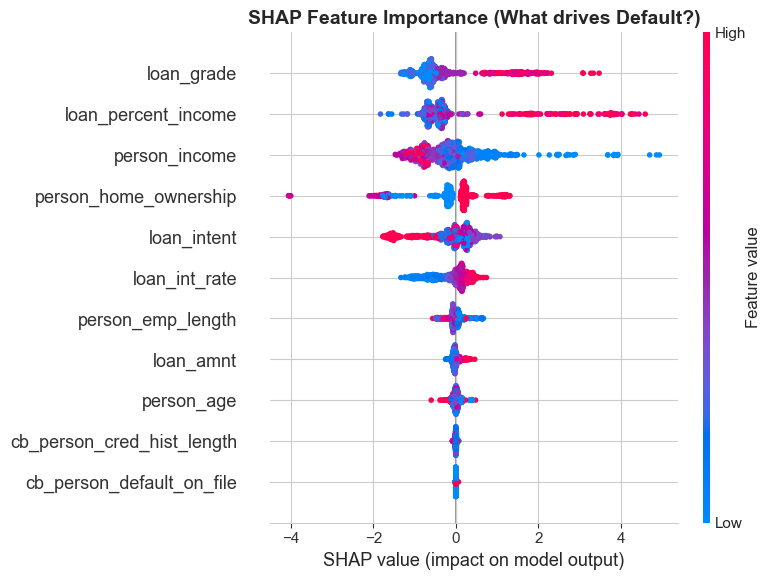

In [49]:
# DATA PREPARATION
# Use the XGBoost model and a sample of the test data
# Note: SHAP can be slow, so we use a sample of 1000 rows
X_sample = X_test_xgb.sample(1000, random_state=42)
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_sample)

# PLOTTING
plt.figure(figsize=(10, 6))
plt.title('SHAP Feature Importance (What drives Default?)', fontsize=14, fontweight='bold')

# Create the Beeswarm plot
# show=False allows us to modify the plot before displaying/saving
shap.summary_plot(shap_values, X_sample, show=False)

# Save the plot
# We use bbox_inches='tight' to ensure feature names aren't cut off
plt.savefig('shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()